In [1]:
import re 
import os 
import sys

import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io

from pathlib import Path
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import scanpy as sc
import anndata as ad

sc.settings.verbosity = 3

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

# Read files

In [10]:
# Read adata
path = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / '02.h5ad'
adata = sc.read_h5ad(path)
centroids = adata.obsm["spatial"]
print(adata)

# Read all existing gate name
gating_path = data_dir / 'GC Database' / 'exported_FlowJo_extra_CODEX'  / 'scale_values'
names = []
for (dirpath, dirnames, filenames) in os.walk(gating_path):
    for name in tqdm(sorted(filenames)):
        if 'csv' not in name:
            continue
        names.append(name.split('_')[-1].split('.')[0])
        
        
# Define phenotype to keep 
keep = ['CTLA4+ Cytotoxic T-cells', 'CollagenIV+ Stroma', 'Cytotoxic T-cells (CD8+)', 'FRCs (Podoplanin+CollagenIV+)', 'Follicular dendritic cells (CD19+CD21+)', 'Helper T-cells (CD4+)', 'ICOS+ Cytotoxic T-cells', 'Ki67+ GC B-cells or Plasma cells (CD40+)', 'Ki67+ all B-cells (CD19+)', 'NK cells (CD56+CD57+)', 'PD-1+ Cytotoxic T-cells', 'Plasma Cells (CD19+CD38+)', 'T-cells (CD3+)', 'B-cells (CD19+)']

# Loop through data
phenotypes = []
dfs = []
for (dirpath, dirnames, filenames) in os.walk(gating_path):
    for name in tqdm(sorted(filenames)):
        if 'csv' not in name:
            continue
        phenotype = name.split('_')[-1].split('.')[0]
        if phenotype in keep:
            df = pd.read_csv(os.path.join(dirpath, name))
            df['Phenotype'] = phenotype
            phenotypes.append(phenotype)
            dfs.append(df)   

# Concatenate
df = pd.concat(dfs)

# Check number of duplicated gates
df.duplicated(subset=['Cell', 'Tissue']).value_counts()

df_new = df.drop_duplicates(subset=['Cell', 'Tissue'], keep='first')

phenotypes_mapped = ['CTLA4+ Cytotoxic T-cells', 'CollagenIV+ Stroma', 'Cytotoxic T-cells', 
                     'FRCs', 'FDCs', 'Helper T-cells', 'ICOS+ Cytotoxic T-cells', 
                     'Ki67+ GC B-cells', 'Ki67+ all B-cells', 'NK cells', 
                     'PD-1+ Cytotoxic T-cells', 'Plasma Cells', 
                     'T-cells', 'B-cells']

p_mapping = dict(zip(phenotypes, phenotypes_mapped))

df_new['Phenotype_mapped'] = df_new.apply(lambda x: p_mapping[x['Phenotype']], axis=1)

AnnData object with n_obs × n_vars = 1957857 × 43
    obs: 'ProfileID', 'ClusterID', 'sample', 'file_key', 'x_in_file', 'y_in_file', 'follicle_id', 'Cluster Number', 'Cluster class', 'Cluster name', 'Cell_Id', 'Tissue'
    obsm: 'spatial'


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_61012\1662725536.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Phenotype_mapped'] = df_new.apply(lambda x: p_mapping[x['Phenotype']], axis=1)


# Create anndata

In [11]:
df_new.columns

Index(['CD104', 'CD117', 'CD11b', 'CD123', 'CD15', 'CD152', 'CD16', 'CD19',
       'CD1c', 'CD2', 'CD21', 'CD22', 'CD27', 'CD273', 'CD278', 'CD279', 'CD3',
       'CD31', 'CD34', 'CD38', 'CD4', 'CD40', 'CD45', 'CD45RA', 'CD49f', 'CD5',
       'CD54', 'CD56', 'CD57', 'CD63', 'CD66', 'CD7', 'CD8', 'CD9', 'Cd81',
       'Cd90', 'Cell', 'CollagenIV', 'Cytokeratin', 'HLADR', 'IgM', 'Ki67',
       'Tissue', 'Vimentin', 'X', 'Y', 'podoplanin', 'Phenotype',
       'Phenotype_mapped'],
      dtype='object')

In [12]:
markers = ['CD104', 'CD117', 'CD11b', 'CD123', 'CD15', 'CD152', 'CD16', 'CD19',
       'CD1c', 'CD2', 'CD21', 'CD22', 'CD27', 'CD273', 'CD278', 'CD279', 'CD3',
       'CD31', 'CD34', 'CD38', 'CD4', 'CD40', 'CD45', 'CD45RA', 'CD49f', 'CD5',
       'CD54', 'CD56', 'CD57', 'CD63', 'CD66', 'CD7', 'CD8', 'CD9', 'Cd81',
       'Cd90', 'CollagenIV', 'Cytokeratin', 'HLADR', 'IgM', 'Ki67',
       'Vimentin',  'podoplanin']
obs = ['Tissue', 'Cell', 'X', 'Y', 'Phenotype', 'Phenotype_mapped']

adata = ad.AnnData(df_new.loc[:,markers])
adata.var_names = markers
adata.obs = df_new.loc[:,obs]
adata.obsm['spatial'] = df_new[['Y', 'X']].values

C:\Users\thu71\AppData\Local\Temp\ipykernel_61012\1230751714.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(df_new.loc[:,markers])
C:\Users\thu71\.conda\envs\thomas-env\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


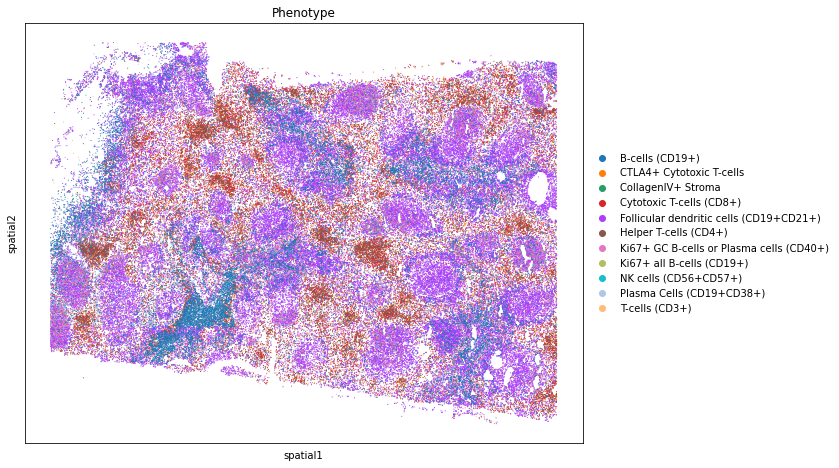

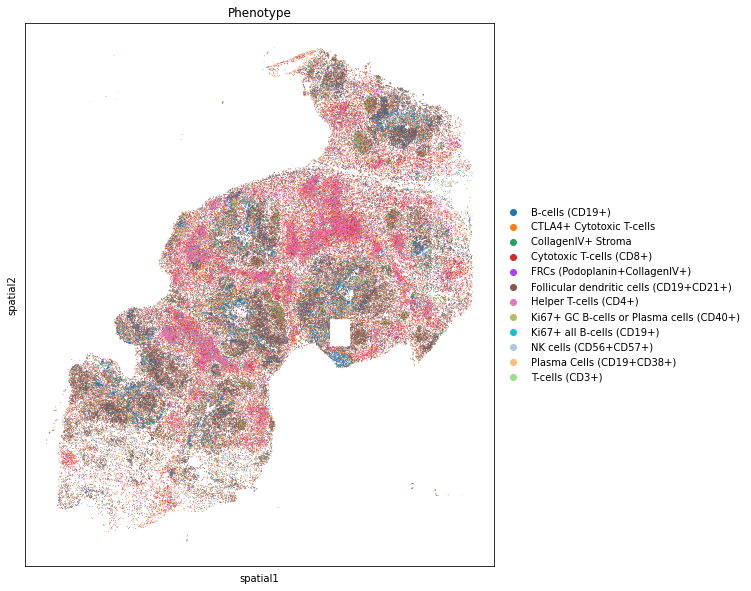

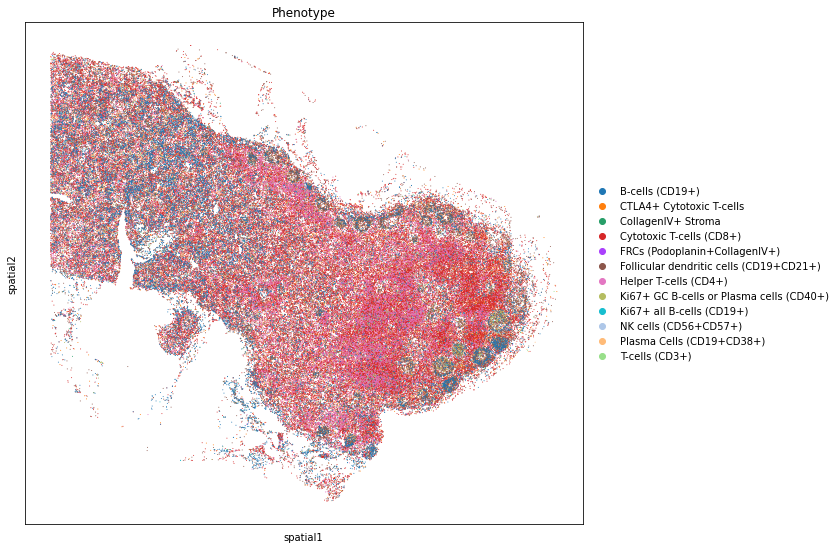

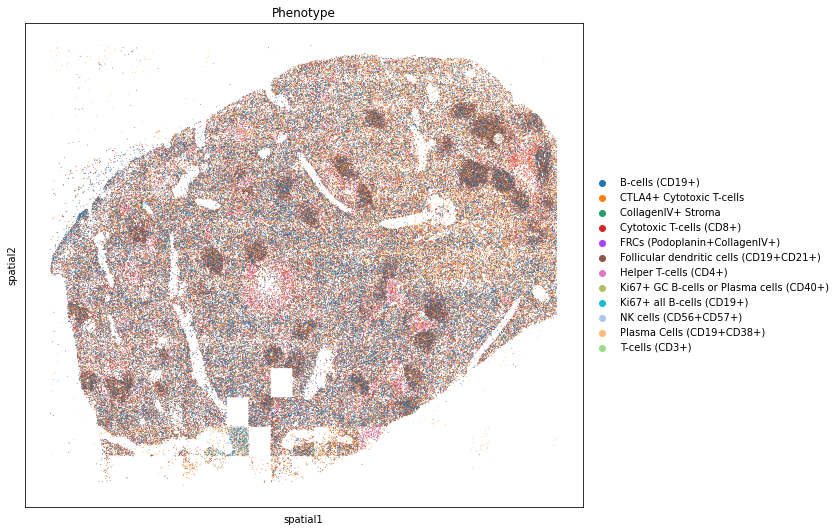

In [15]:
for t in adata.obs.Tissue.unique():
    adata_s = adata[adata.obs.Tissue == t]
    fig, ax = plt.subplots(figsize=(10,10))
    sc.pl.spatial(adata_s, ax=ax, color='Phenotype', spot_size=40)

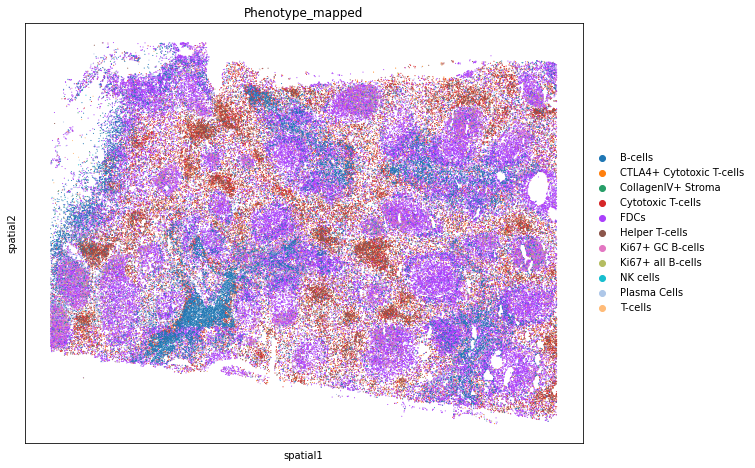

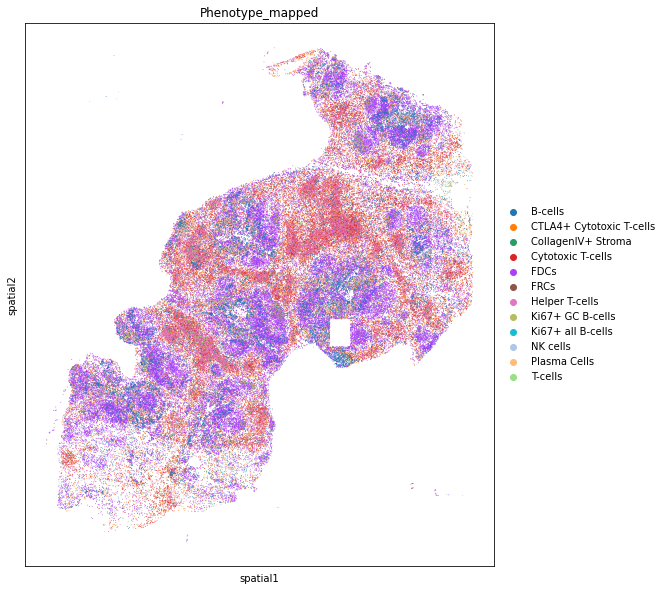

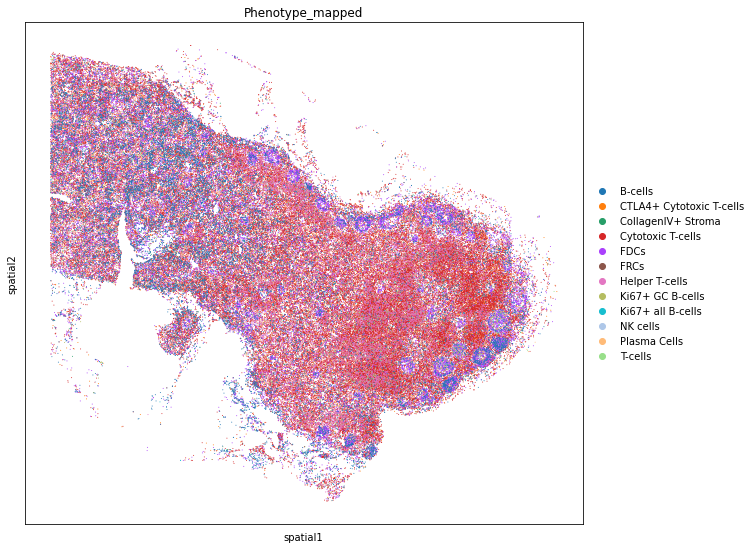

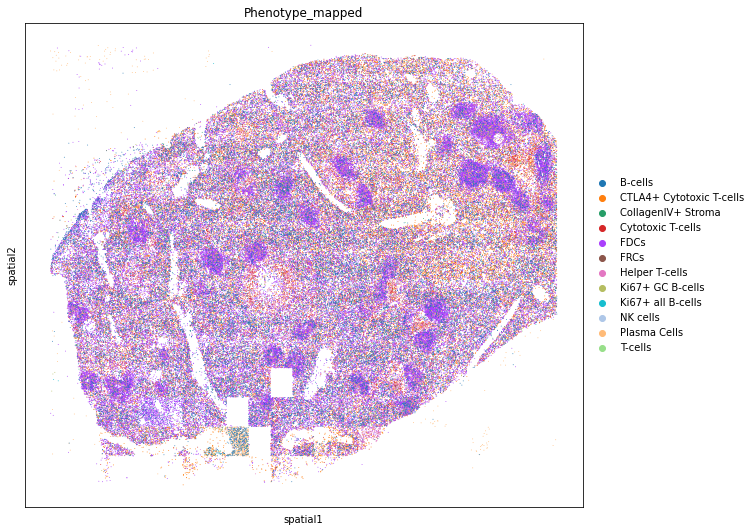

In [16]:
for t in adata.obs.Tissue.unique():
    adata_s = adata[adata.obs.Tissue == t]
    fig, ax = plt.subplots(figsize=(10,10))
    sc.pl.spatial(adata_s, ax=ax, color='Phenotype_mapped', spot_size=40)

# Unsupervised clustering

In [3]:
adata_path = data_dir / "metadata" / f"02_codex.h5ad"


In [18]:
import openTSNE

In [19]:
sc.pp.scale(adata, max_value=4)

In [20]:
%%time
aff50 = openTSNE.affinity.PerplexityBasedNN(
    adata.X,
    perplexity=50,
    n_jobs=32,
    random_state=0,
)

CPU times: total: 19min 25s
Wall time: 3min 35s


In [21]:
%%time
init = openTSNE.initialization.pca(adata.X, random_state=0)

CPU times: total: 22 s
Wall time: 2.22 s


In [22]:
%%time
embedding = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff50, initialization=init)

--------------------------------------------------------------------------------
TSNE(n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=59388.17 for 250 iterations...
Iteration   50, KL divergence 8.1869, 50 iterations in 30.8508 sec
Iteration  100, KL divergence 7.8671, 50 iterations in 31.2857 sec
Iteration  150, KL divergence 7.8158, 50 iterations in 31.0599 sec
Iteration  200, KL divergence 7.7904, 50 iterations in 31.9202 sec
Iteration  250, KL divergence 7.7842, 50 iterations in 32.2634 sec
   --> Time elapsed: 157.38 seconds
===> Running optimization with exaggeration=1.00, lr=59388.17 for 500 iterations...
Iteration   50, KL divergence 6.0657, 50 iterations in 31.3443 sec
Iteration  100, KL divergence 5.5379, 50 iterations in 30.7492 sec
Iteration  150, KL divergence 5.2622, 50 iterations in 31.3049 sec
Iteration  200, KL divergence 5.0849, 50 iterations in 32.9070 sec


In [23]:
adata.obsm['X_tsne'] = np.array(embedding)
adata.obs['Tissue'] = adata.obs['Tissue'].astype(np.uint8)
adata.obs['Cell'] = adata.obs['Cell'].astype(np.uint32)

In [24]:
adata.write(adata_path)

In [25]:
adata

AnnData object with n_obs × n_vars = 712658 × 43
    obs: 'Tissue', 'Cell', 'X', 'Y', 'Phenotype', 'Phenotype_mapped'
    var: 'mean', 'std'
    obsm: 'spatial', 'X_tsne'

In [4]:
adata = sc.read_h5ad(adata_path)

C:\Users\thu71\Anaconda3\envs\PLA\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\Anaconda3\envs\PLA\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
sc.pp.neighbors(adata, n_neighbors=30)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:41)


In [6]:
adata

AnnData object with n_obs × n_vars = 712658 × 43
    obs: 'Tissue', 'Cell', 'X', 'Y', 'Phenotype', 'Phenotype_mapped'
    var: 'mean', 'std'
    uns: 'neighbors'
    obsm: 'X_tsne', 'spatial'
    obsp: 'distances', 'connectivities'

In [7]:
sc.tl.leiden(adata, resolution=1.0)

running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (1:32:50)


In [8]:
adata.write(adata_path)

# Analysis

In [3]:
adata_path = data_dir / "metadata" / f"02_codex.h5ad"
adata = ad.read_h5ad(adata_path)

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
